In [57]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [58]:
# === 参数配置部分 ===
# 输入和输出文件路径
INPUT_IMAGE_PATH = 'F:/B208/DeepLearning_assists/Figure3/label//predicted/arrayinput_0000.png'
OUTPUT_IMAGE_PATH = 'F:/B208/DeepLearning_assists/Figure3/label/Recombined/arrayinput_0000.png'
HISTOGRAM_FILE_PATH = 'F:/B208/DeepLearning_assists/Figure3/label/Recombined/output_pixel_distribution_histogram.png'
OUTPUT_TXT_PATH = 'F:/B208/DeepLearning_assists/Figure3/label/Recombined/output_angle_distribution.txt'

In [59]:
# === 核心功能模块 ===
def load_image(image_path):
    """加载二值化图像"""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"无法加载图像: {image_path}")
    return image

In [60]:
def hough_transform(binary_image):
    """使用霍夫变换提取直线"""
    return cv2.HoughLinesP(binary_image, 1, np.pi / 360, 100, minLineLength=3, maxLineGap=2)

In [61]:
def calculate_angle_distribution(lines):
    """计算线条的角度分布和像素分布"""
    angle_counts = {}
    pixel_distribution = {}

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
            angle = (angle + 180) % 180  # 统一角度范围为 [0, 180)
            angle = int(angle)

            if angle not in angle_counts:
                angle_counts[angle] = 0
                pixel_distribution[angle] = []

            angle_counts[angle] += 1
            pixels = bresenham(x1, y1, x2, y2)
            pixel_distribution[angle].extend(pixels)

    return angle_counts, pixel_distribution

def bresenham(x1, y1, x2, y2):
    """使用 Bresenham 算法生成线段像素坐标"""
    pixels = []
    dx, dy = abs(x2 - x1), abs(y2 - y1)
    sx, sy = (1 if x1 < x2 else -1), (1 if y1 < y2 else -1)
    err = dx - dy

    while True:
        pixels.append((x1, y1))
        if x1 == x2 and y1 == y2:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy

    return pixels

In [62]:
def draw_lines(binary_image, lines):
    """将检测到的线条绘制到图像上"""
    combined_image = np.zeros_like(binary_image)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(combined_image, (x1, y1), (x2, y2), 255, 1)
    return combined_image

def save_histogram(angle_counts, pixel_distribution, save_path):
    """绘制并保存角度分布直方图"""
    angles = list(angle_counts.keys())
    pixel_counts = [len(pixel_distribution.get(angle, [])) for angle in angles]
    total_pixels = sum(pixel_counts)
    normalized_distribution = [count / total_pixels for count in pixel_counts]

    # 计算 88-92 度的像素占比
    relevant_pixels = sum(len(pixel_distribution.get(angle, [])) for angle in range(88, 93))
    relevant_percentage = relevant_pixels / total_pixels if total_pixels > 0 else 0

    plt.figure(figsize=(3, 3), dpi=100)
    plt.bar(angles, normalized_distribution, width=1, color='red', edgecolor='red')
    plt.xlabel('Angle (degrees)', fontfamily='Arial')
    plt.ylabel('Pixels (Normalized)', fontfamily='Arial')
    plt.title('Pixel Distribution by Angle', fontfamily='Arial')
    plt.text(10, 0.9, f"88-92 degrees ratio: {relevant_percentage:.2%}", fontsize=10, fontfamily='Arial', color='black')
    plt.axvspan(88, 92, color='red', alpha=0.3, label='88-92 degrees')
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"角度分布直方图已保存至: {save_path}")

def save_angle_distribution(angle_counts, output_path):
    """保存角度分布数据到文本文件"""
    with open(output_path, 'w') as f:
        f.write('Angle (degrees), Count\n')
        for angle, count in angle_counts.items():
            f.write(f'{angle}, {count}\n')
    print(f"角度分布数据已保存至: {output_path}")

组合图像已保存至: F:/B208/DeepLearning_assists/Figure3/label/Recombined/arrayinput_0000.png
角度分布数据已保存至: F:/B208/DeepLearning_assists/Figure3/label/Recombined/output_angle_distribution.txt


C:\Users\zhang\AppData\Local\Temp\ipykernel_3344\1387610359.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


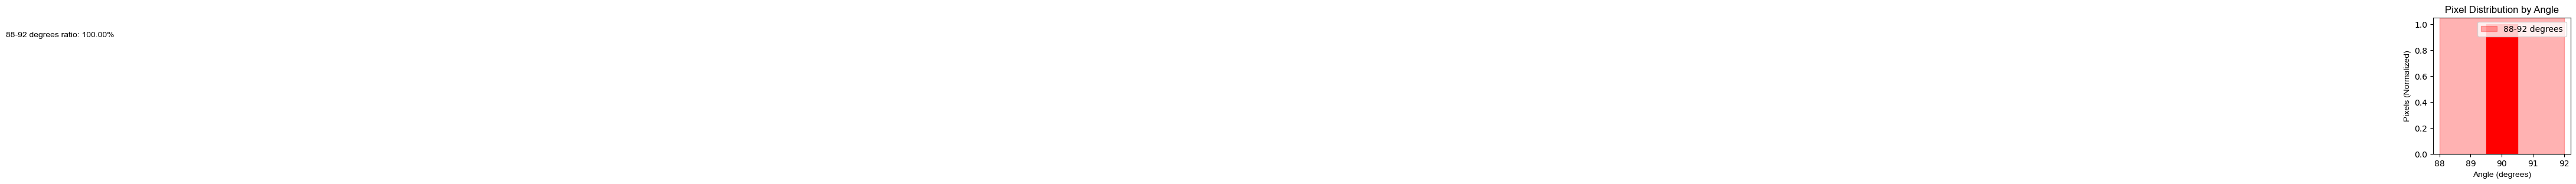

角度分布直方图已保存至: F:/B208/DeepLearning_assists/Figure3/label/Recombined/output_pixel_distribution_histogram.png


In [63]:
# === 主流程 ===
def main():
    try:
        # 1. 加载图像
        binary_image = load_image(INPUT_IMAGE_PATH)

        # 2. 检测线条
        lines = hough_transform(binary_image)

        # 3. 计算角度和像素分布
        angle_counts, pixel_distribution = calculate_angle_distribution(lines)

        # 4. 绘制并保存线条组合图像
        combined_image = draw_lines(binary_image, lines)
        if cv2.imwrite(OUTPUT_IMAGE_PATH, combined_image):
            print(f"组合图像已保存至: {OUTPUT_IMAGE_PATH}")
        else:
            print(f"组合图像保存失败！")

        # 5. 保存角度分布到文件
        save_angle_distribution(angle_counts, OUTPUT_TXT_PATH)

        # 6. 绘制并保存角度直方图
        save_histogram(angle_counts, pixel_distribution, HISTOGRAM_FILE_PATH)

    except Exception as e:
        print(f"处理过程中发生错误: {e}")

if __name__ == "__main__":
    main()